In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow mtcnn opencv-python scikit-learn lz4 facenet-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 149.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 167.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 172.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB

In [2]:
import os
import time
from PIL import Image
import numpy as np
import torch
import pickle
from keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
import tqdm
import shutil
from tqdm import tqdm

# use GPU if it's there, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


In [1]:
import zipfile  # to handle zip files
zip_path = '/content/vggface2_small.zip'
extract_dir = '/content/vggface2_small'

# unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(extract_dir)  # print the folder path


/content/vggface2_small


In [4]:
# using MobileNetV2 for face classification
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tqdm.notebook import tqdm
import os

# basic setup
DATA_DIR = '/content/vggface2_small/vggface2_small'
IMG_SIZE = (160, 160)
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

# progress bar callback for training
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progbar = tqdm(total=self.epochs, desc='Training Progress')
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs['accuracy'] * 100
        val_acc = logs['val_accuracy'] * 100
        print(f"\n Epoch {epoch+1}/{self.epochs} Metrics:")
        print(f"   - loss:        {logs['loss']:.4f}")
        print(f"   - accuracy:    {train_acc:.2f}%")
        print(f"   - val_loss:    {logs['val_loss']:.4f}")
        print(f"   - val_accuracy:{val_acc:.2f}%")
        self.progbar.set_description(f"Epoch {epoch+1}/{self.epochs} ✓")
        self.progbar.update(1)
    def on_train_end(self, logs=None):
        self.progbar.close()

# load and augment data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# training data
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

# validation data
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# build the model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[TQDMProgressBar()],
    verbose=0
)

# save the model
model.save('/content/drive/MyDrive/cv_project/mobilenet.h5', include_optimizer=False)
print("model saved")


In [5]:
# resnet model for face classification

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tqdm.notebook import tqdm
import os

# setup
DATA_DIR = '/content/vggface2_small/vggface2_small'
IMG_SIZE = (160, 160)
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42


# prepare image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# load training data
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

# load validation data
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# build model
from tensorflow.keras.layers import BatchNormalization, Dropout

base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# freeze layers
for layer in base_model.layers:
    layer.trainable = False

# compile and train
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[TQDMProgressBar()],
    verbose=0
)

# save model
model.save("resnet50_vggface2.keras", include_optimizer=False)
print("model saved")


In [6]:
# efficientnet model for face classification
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# make the model
base_model = EfficientNetB0(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# unfreeze last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

# compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train and save
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[TQDMProgressBar()],
    verbose=0
)

model.save('/content/drive/MyDrive/cv_project/efficientnetb0_vggface2.h5')
print("model saved")


Found 1000 images belonging to 100 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


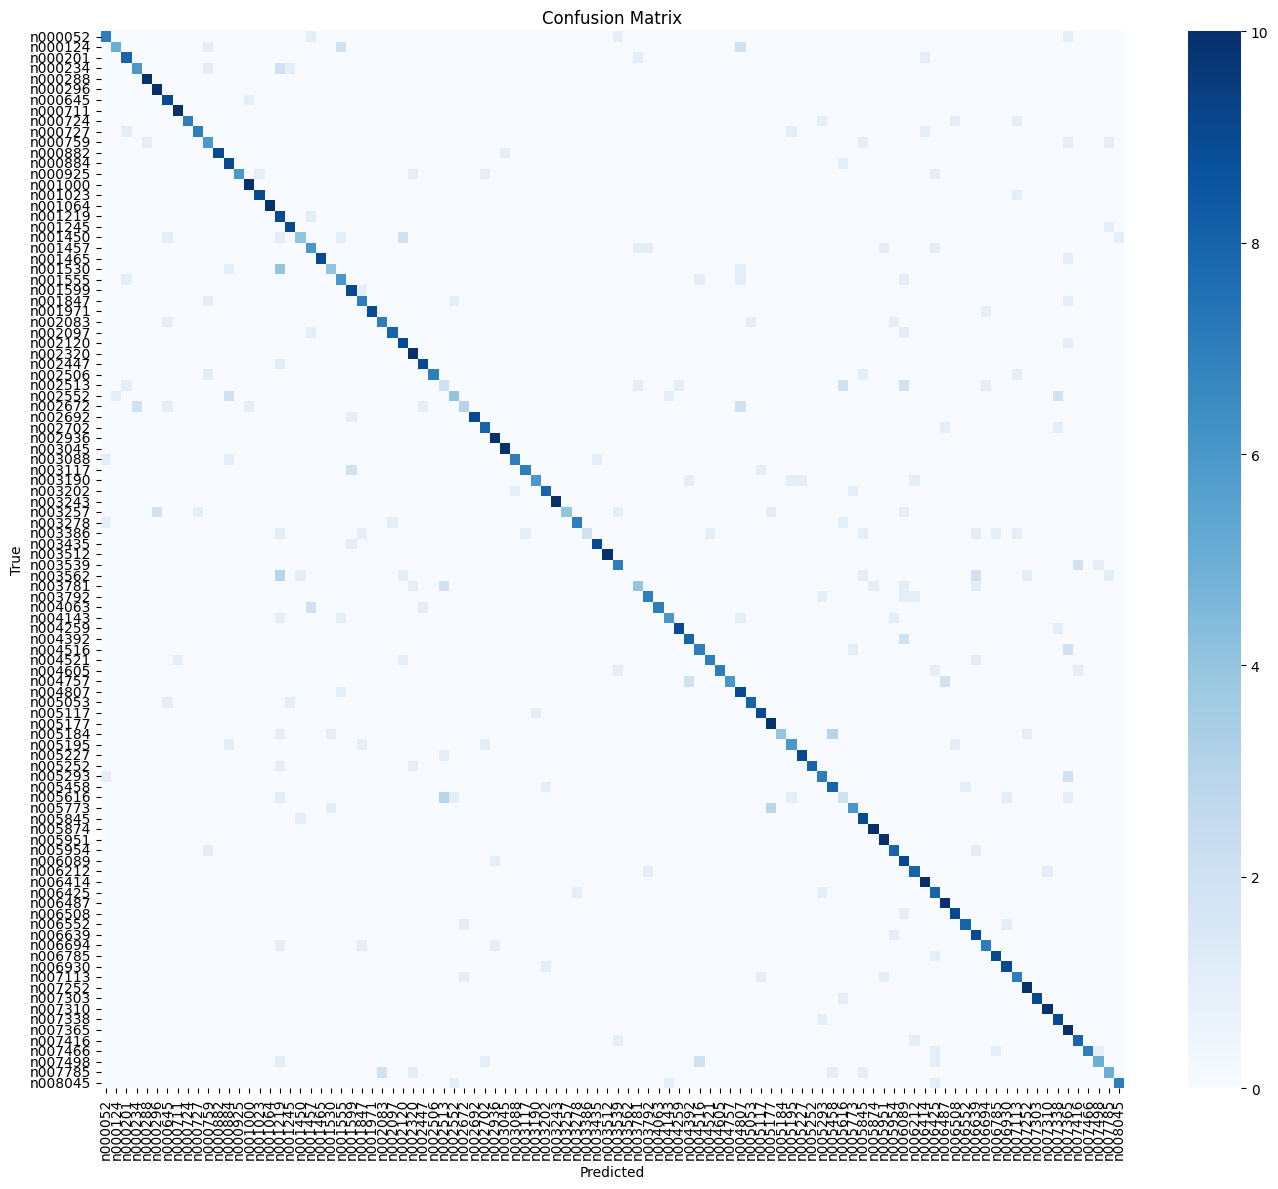

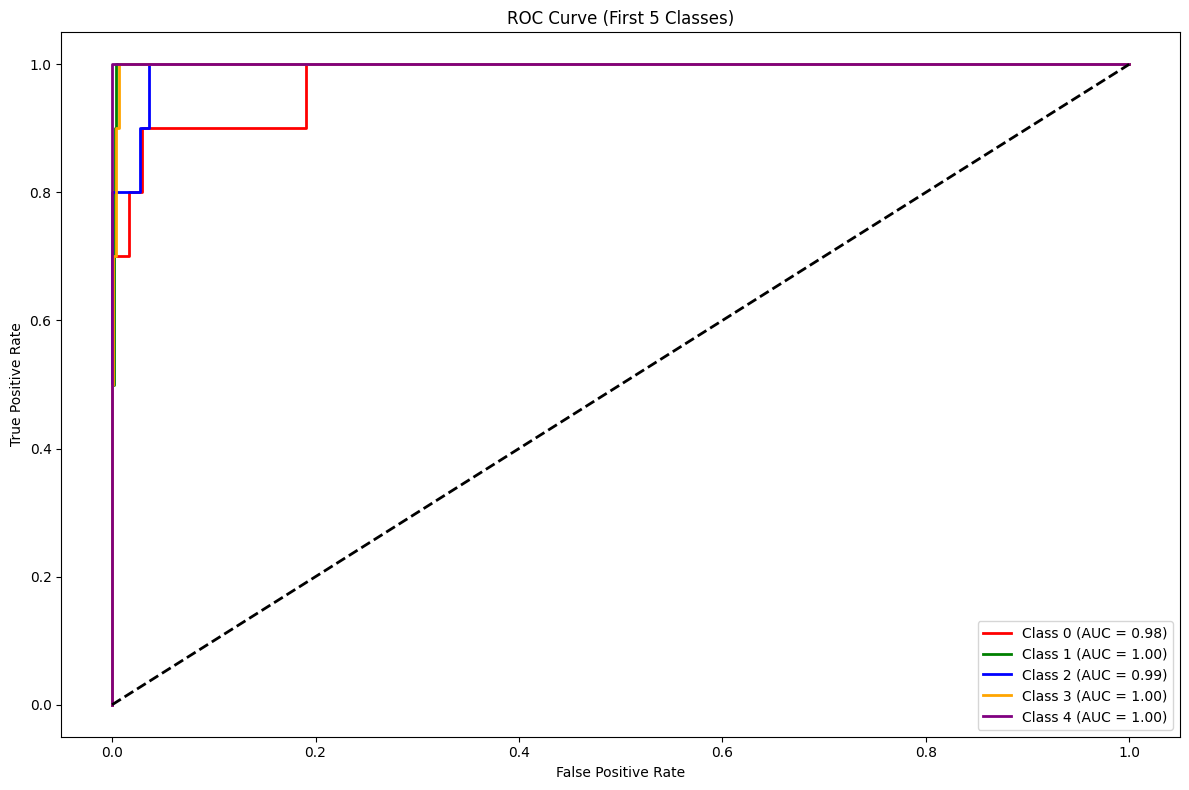

In [7]:
# metrics

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import numpy as np

# load the trained MobileNet model without compiling again
model = load_model('/content/mobilenet_clean.h5', compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# prepare validation data using the same image size and split
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = val_datagen.flow_from_directory(
    '/content/vggface2_small/vggface2_small',
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# make predictions and get true and predicted labels
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# create and plot the confusion matrix to compare predictions
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", xticklabels=val_gen.class_indices, yticklabels=val_gen.class_indices)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("/content/confusion_matrix.png")
plt.show()

# calculate ROC curves and AUC scores for each class
num_classes = y_pred_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curves for the first 5 classes to visualize performance
plt.figure(figsize=(12, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
for i, color in zip(range(min(5, num_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (First 5 Classes)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("/content/roc_curve.png")
plt.show()


Found 1000 images belonging to 100 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


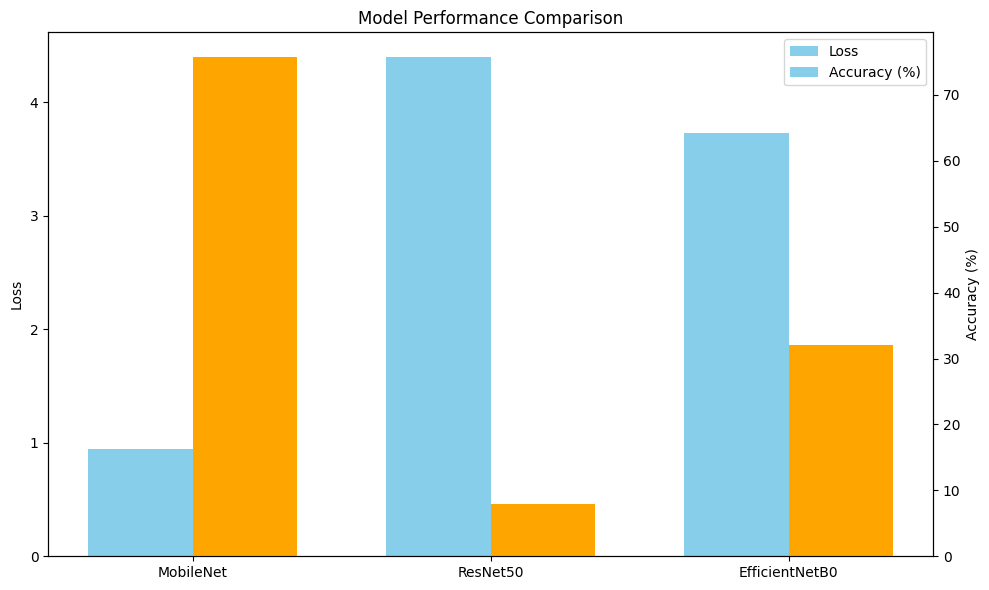

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# set common config values for data path, image size, and batch size
DATA_DIR = '/content/vggface2_small/vggface2_small'
IMG_SIZE = (160, 160)
BATCH_SIZE = 16

# load the validation images from the folder without shuffling
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# define a function to load and evaluate a model on the validation set
def evaluate_model(model_path):
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    loss, acc = model.evaluate(val_gen, verbose=0)
    return loss, acc * 100  # return loss and accuracy (converted to percentage)

# evaluate all models and store the results in a dictionary
results = {}
results["MobileNet"] = evaluate_model('/content/mobilenet_clean.h5')
results["ResNet50"] = evaluate_model('/content/resnet50_vggface2.h5')
results["EfficientNetB0"] = evaluate_model('/content/efficientnetb0_vggface2.h5')

# prepare the data for plotting bar charts
models = list(results.keys())
losses = [results[m][0] for m in models]
accuracies = [results[m][1] for m in models]

x = range(len(models))
width = 0.35

# create side-by-side bars for loss and accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
bar1 = ax1.bar([i - width/2 for i in x], losses, width, label='Loss', color='skyblue')
bar2 = ax2.bar([i + width/2 for i in x], accuracies, width, label='Accuracy (%)', color='orange')

# add axis labels and titles
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('Model Performance Comparison')

# add legend and save the plot as an image
bars = bar1 + bar2
labels = [bar.get_label() for bar in bars]
plt.legend(bars, ['Loss', 'Accuracy (%)'], loc='upper right')
plt.tight_layout()
plt.savefig('/content/model_comparison.png')
plt.show()


# **Website integration**


In [10]:
import cv2  # to work with video and images

video_path = '/content/sample_video.mp4'
cap = cv2.VideoCapture(video_path)  # open the video file for reading


In [12]:
import os, cv2, numpy as np  # for file handling, video processing, and arrays
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# load the trained face embedding model
embedding_model = load_model('/content/mobilenet_clean.h5', compile=False)

# load OpenCV's built-in face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# resize and normalize face image for the model
def preprocess_face(face):
    face = cv2.resize(face, (160, 160))
    face = img_to_array(face)
    face = preprocess_input(face)
    return np.expand_dims(face, axis=0)

# get the feature vector (embedding) from the model
def get_embedding(face_tensor):
    embedding = embedding_model.predict(face_tensor, verbose=0)[0]
    return normalize([embedding])[0]

# check if this face is different from previously seen ones
def is_unique_face(embedding, known_embeddings, threshold=0.75):
    if not known_embeddings:
        return True
    sims = cosine_similarity([embedding], known_embeddings)
    return np.max(sims) < threshold

# read video file
video_path = '/content/sample2.mp4'
cap = cv2.VideoCapture(video_path)

# folder to save new unique faces
os.makedirs("unique_faces", exist_ok=True)

known_embeddings = []  # store feature vectors of known faces
unique_count = 0  # count of unique faces
frame_count = 0  # number of frames processed

try:
    while True:
        ret, frame = cap.read()  # read each frame
        if not ret:
            break
        frame_count += 1

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale for detection
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)  # detect faces in the frame

        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]  # extract the face region
            if face.size == 0:
                continue

            try:
                preprocessed = preprocess_face(face)  # prepare face for model
                embedding = get_embedding(preprocessed)  # get its feature vector

                if is_unique_face(embedding, known_embeddings):  # check if it's a new face
                    known_embeddings.append(embedding)
                    filename = f"unique_faces/person_{unique_count}.jpg"
                    cv2.imwrite(filename, face)  # save the face image
                    if unique_count % 5 == 0:
                        print(f".")
                    unique_count += 1

            except Exception as e:
                print(f"[{e}")  # show error if face fails

finally:
    cap.release()  # release video
    print(f" {unique_count}")  # summary output


.
.
.
.
.
.

✅ Done! Total unique faces saved: 29


✅ Loaded 2 banned individuals
✅ Match: person_16.jpg ↔ sumi.jpeg (Similarity: 0.78)


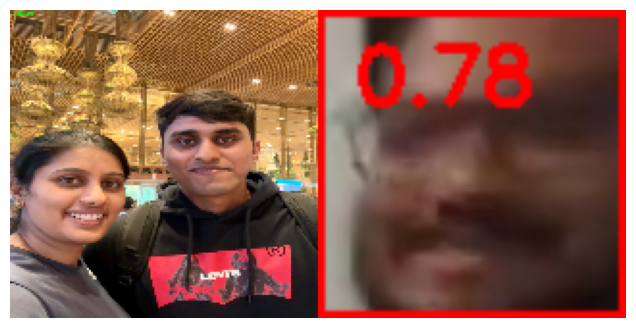

✅ Match: person_16.jpg ↔ ajashithnithesh.jpg (Similarity: 0.79)


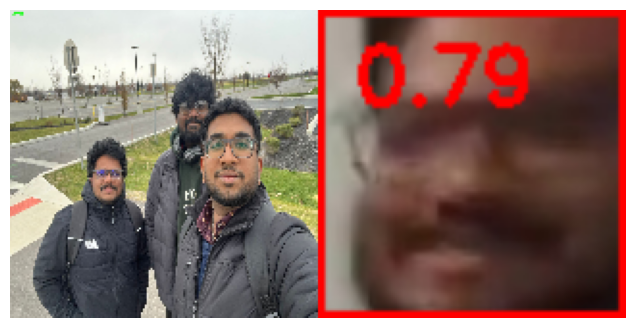

✅ Match: person_6.jpg ↔ ajashithnithesh.jpg (Similarity: 0.79)


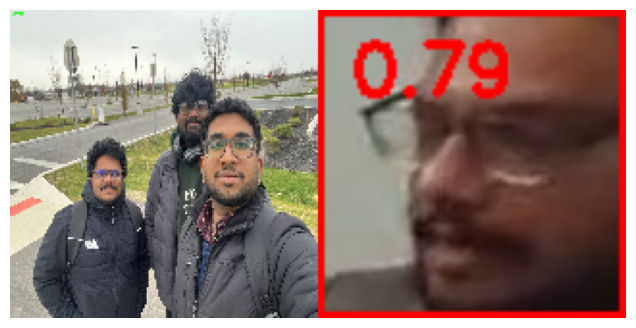

✅ Match: person_4.jpg ↔ sumi.jpeg (Similarity: 0.78)


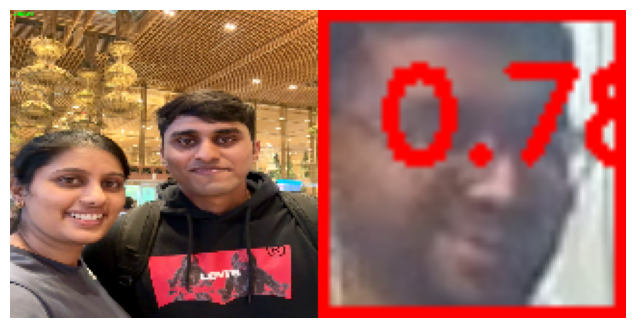

✅ Match: person_4.jpg ↔ ajashithnithesh.jpg (Similarity: 0.79)


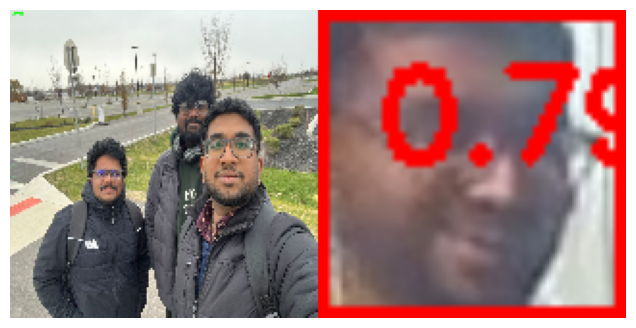

✅ Match: person_1.jpg ↔ sumi.jpeg (Similarity: 0.79)


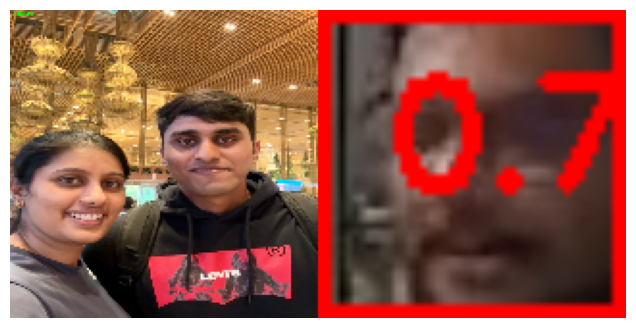

✅ Match: person_1.jpg ↔ ajashithnithesh.jpg (Similarity: 0.78)


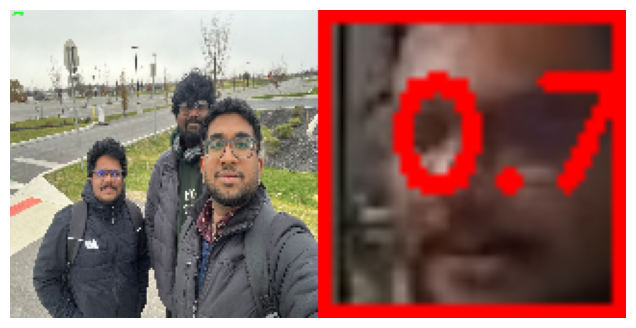

✅ Match: person_28.jpg ↔ ajashithnithesh.jpg (Similarity: 0.78)


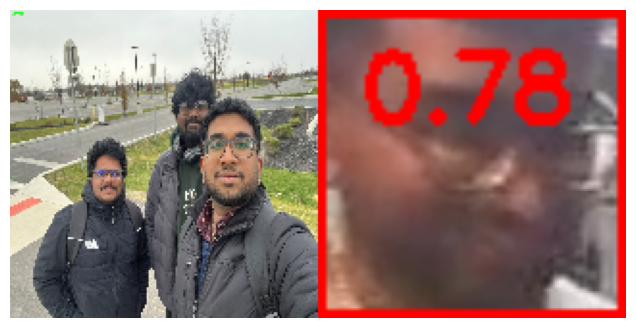

✅ Match: person_10.jpg ↔ sumi.jpeg (Similarity: 0.77)


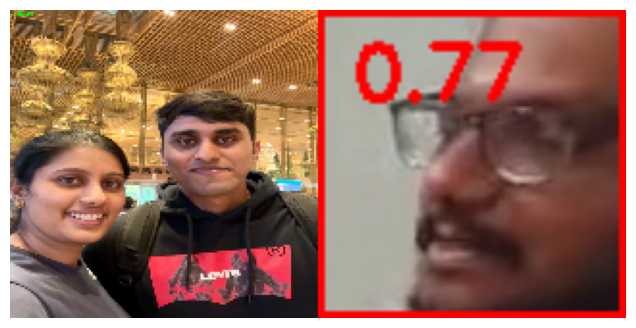

✅ Match: person_10.jpg ↔ ajashithnithesh.jpg (Similarity: 0.77)


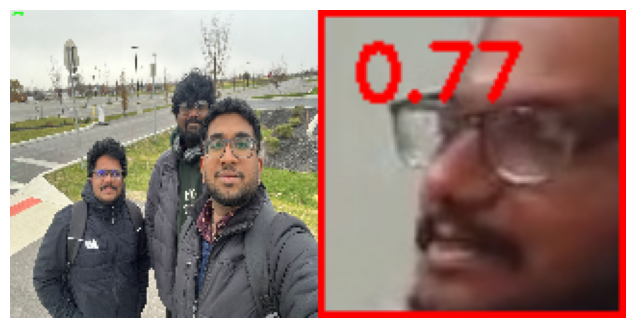

✅ Match: person_13.jpg ↔ sumi.jpeg (Similarity: 0.79)


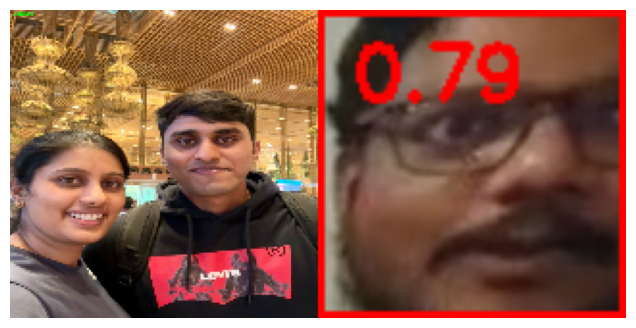

✅ Match: person_13.jpg ↔ ajashithnithesh.jpg (Similarity: 0.79)


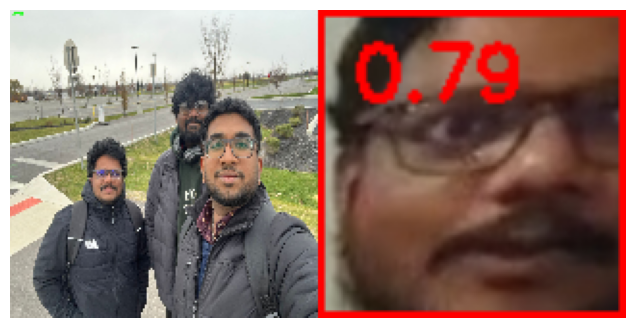

✅ Match: person_27.jpg ↔ ajashithnithesh.jpg (Similarity: 0.79)


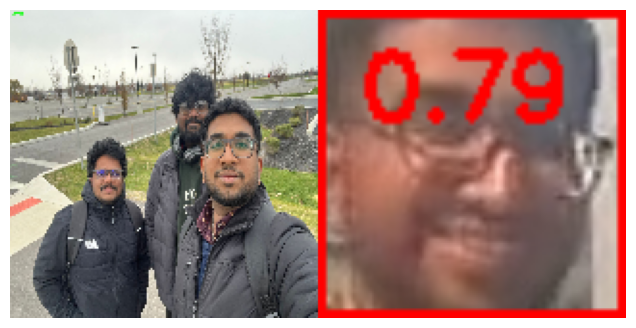

✅ Match: person_5.jpg ↔ ajashithnithesh.jpg (Similarity: 0.80)


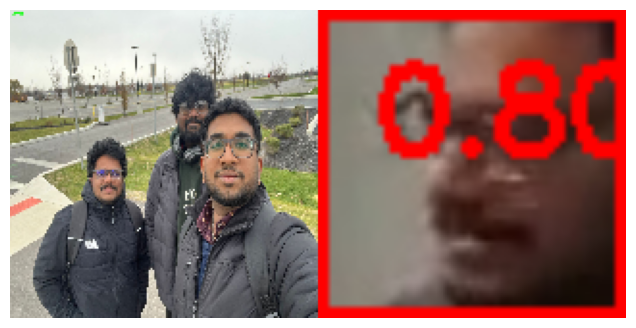

In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# set paths for banned faces, detected unique faces, and the trained model
banned_dir = "/content/drive/MyDrive/cv_project/banned_individuals"
unique_faces_dir = "unique_faces"
model_path = "/content/mobilenet_clean.h5"
threshold = 0.77  # similarity threshold to consider a match

# load the trained face embedding model and cut off the last layer
base_model = load_model(model_path, compile=False)
embedding_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# load and prepare a face image for prediction
def preprocess_face(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (160, 160))
    image = img_to_array(image)
    image = preprocess_input(image)
    return np.expand_dims(image, axis=0)

# get the feature vector (embedding) from the model
def get_embedding(face_tensor):
    return embedding_model.predict(face_tensor, verbose=0)[0]

# process each banned face image to get its embedding and store it
banned_embeddings = {}
banned_images = {}
for filename in os.listdir(banned_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        path = os.path.join(banned_dir, filename)
        tensor = preprocess_face(path)
        banned_embeddings[filename] = get_embedding(tensor)
        banned_images[filename] = cv2.imread(path)


# check each detected face against all banned face embeddings
for unique_filename in os.listdir(unique_faces_dir):
    if not unique_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    unique_path = os.path.join(unique_faces_dir, unique_filename)
    tensor = preprocess_face(unique_path)
    unique_embedding = get_embedding(tensor)
    original_img = cv2.imread(unique_path)

    for banned_name, banned_embedding in banned_embeddings.items():
        similarity = cosine_similarity([unique_embedding], [banned_embedding])[0][0]

        if similarity > threshold:
            print(f"Match: {unique_filename} = {banned_name} (Similarity: {similarity:.2f})")

            # draw red box and similarity score on matched face image
            face_with_box = original_img.copy()
            h, w = face_with_box.shape[:2]
            cv2.rectangle(face_with_box, (0, 0), (w - 1, h - 1), (0, 0, 255), 2)
            cv2.putText(face_with_box, f"{similarity:.2f}", (10, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # draw green box and label "Banned" on the banned person image
            banned_img = banned_images[banned_name].copy()
            bh, bw = banned_img.shape[:2]
            cv2.rectangle(banned_img, (0, 0), (bw - 1, bh - 1), (0, 255, 0), 2)
            cv2.putText(banned_img, "Banned", (10, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # resize both images and convert to RGB for displaying
            target_size = (160, 160)
            face_rgb = cv2.cvtColor(cv2.resize(face_with_box, target_size), cv2.COLOR_BGR2RGB)
            banned_rgb = cv2.cvtColor(cv2.resize(banned_img, target_size), cv2.COLOR_BGR2RGB)

            # show banned face and matched face side by side
            combined = np.hstack((banned_rgb, face_rgb))
            plt.figure(figsize=(8, 4))
            plt.imshow(combined)
            plt.axis('off')
            plt.show()


In [ ]:
output_dir = "matched_outputs"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, f"{unique_filename}_matched_with_{banned_name}.jpg")
cv2.imwrite(output_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))